# Reinforcement Learning - Deep Q Network
If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [4]:
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [5]:
%%execwritefile dqn_autograde.py
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting dqn_autograde.py


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Deep Q-Network (DQN)

In [7]:
import gym
env = gym.envs.make("CartPole-v1")

/home/ankur/miniconda3/envs/rlcourse/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [9]:
# # dir(env)
# env.reset()
# dir(env.step(env.action_space.sample())[0])

In [10]:
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [11]:
%%execwritefile -a dqn_autograde.py

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        # YOUR CODE HERE
        model = torch.nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2,
        )
        return model(x)

Appending to dqn_autograde.py


In [12]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1)
Q_net = QNetwork(num_hidden)

torch.manual_seed(1)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(Q_net(x).numpy(), test_model(x).numpy())

### 2.2 Experience Replay

In order to stabilize learning, we will use an experience replay to save states in and sample states from. Now implement the `push` function that adds a transition to the replay buffer, and the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`). It should keep at most the maximum number of transitions.

In [13]:
%%execwritefile -a dqn_autograde.py

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        self.memory.append(transition)
        if len(self.memory) > capacity: self.memory = self.memory[-self.capacity:]
        
    def sample(self, batch_size):
        # YOUR CODE HERE
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Appending to dqn_autograde.py


In [14]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([ 0.00626136, -0.04149265, -0.00152061,  0.01808672]), 0, 1.0, array([ 0.00543151, -0.23659276, -0.00115888,  0.31028949]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [15]:
%%execwritefile -a dqn_autograde.py

def get_epsilon(it):
    # YOUR CODE HERE
    EPS_START = 1
    EPS_END = 0.05
    IT_CONSTANT = 1000
    
    epsilon = EPS_START + (EPS_END - EPS_START)/IT_CONSTANT * it if it < IT_CONSTANT else EPS_END
    
    return epsilon

Appending to dqn_autograde.py


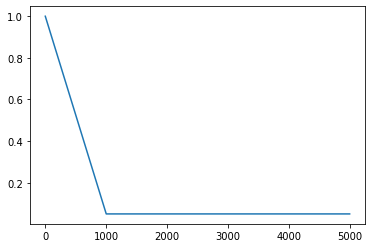

In [16]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

Now write a function of *EpsilonGreedyPolicy* class. This function takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon. Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [17]:
%%execwritefile -a dqn_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        
        obs = torch.from_numpy(np.array(obs.astype(np.float32)))
        
        with torch.no_grad():
            q = self.Q.forward(obs)
        
        
        greediest_action = np.argmax(q).item()
        weights = [(1-self.epsilon)*100.0] + [self.epsilon*100.0/2]*2
        
        action = random.choices([greediest_action, 0, 1], weights=weights, k = 1)
        assert len(action) == 1
            
        return action[0] # Take only element as integer in stead of list
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

Appending to dqn_autograde.py


In [18]:
## TO DO: why are all initial state values initializes U(-0.05, 0.05)?

# states = []
# for _ in range(10000):
#     s = env.reset()
#     states.append(s)
# states = np.array(states).T

# fig, axes = plt.subplots(1, len(states), figsize = (10, 4))

# for ax, state in zip(axes, states):
#     ax.hist(state)
# plt.show()

In [19]:
s = env.reset()
epg = EpsilonGreedyPolicy(Q_net, 0.05)
a = epg.sample_action(s)
assert not torch.is_tensor(a)
print (a)

0


### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [20]:
%%execwritefile -a dqn_autograde.py

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    q = Q.forward(states)
    Q_values = torch.gather(q, 1, actions)    
    return Q_values
    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of rewards. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    targets = rewards + discount_factor * torch.max(Q.forward(next_states))
#     print(targets.shape)
#     print("targets shape: ", targets.shape)
#     print("rewards shape: ", rewards.shape)
#     print("next_states shape: ", next_states.shape)
#     print("dones shape: ", dones.shape)
    
    
    tmp = []
    for done, target, next_state, reward in zip(dones, targets, next_states, rewards):
        if not done:
            tmp.append(target)
        else:
            tmp.append(torch.tensor(reward))
#             tmp.append(torch.tensor([0.0]))
#             tmp.append(next_state)
            
    targets = torch.cat(tmp)
    targets = targets[:, None]
    
#     targets = torch.tensor([target  
#         for done, target in zip(dones, targets)
#     ]).unsqueeze(1)
    
    
#     targets = torch.tensor([
#         target if not done else next_state 
#         for done, target, next_state in zip(dones, targets, next_states)
#     ]).unsqueeze(1)

#     targets = [
#         target if not done else next_state 
#         for done, target, next_state in zip(dones, targets, next_states)
#     ]
    
#     print("final targets shape: ", targets.shape)
    
    return targets
    
    
    
def train(Q, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        print('this is not good:', len(memory), batch_size) # REMOVE THIS LINE
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

Appending to dqn_autograde.py


In [21]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 1.0
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(Q_net.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)

for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(Q_net, memory, optimizer, batch_size, discount_factor)

print(loss)

0.504221498966217


/home/ankur/.local/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484747659/work/torch/csrc/utils/tensor_new.cpp:201.)


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [22]:
%%execwritefile -a dqn_autograde.py

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        state = env.reset()
        
        steps = 0
        while True:
            # YOUR CODE HERE

            # We need a larger memory, fill with dummy data
#             transition = memory.sample(1)[0]
#             memory = ReplayMemory(10 * batch_size)
#             for i in range(batch_size):
#                 memory.push(transition)  

            # Sample a transition
            action = policy.sample_action(state)
            s_next, r, done, _ = env.step(action)

            # Push a transition
            memory.push((state, action, r, s_next, done))
            
            loss = train(Q, memory, optimizer, batch_size, discount_factor)
            
            
            policy.set_epsilon(get_epsilon(i))
            
            state = s_next

            
            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                print("loss: ", loss)
                break
    return episode_durations

Appending to dqn_autograde.py


In [23]:
# Let's run it!
num_episodes = 500
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

this is not good: 1 64
this is not good: 2 64
this is not good: 3 64
this is not good: 4 64
this is not good: 5 64
this is not good: 6 64
this is not good: 7 64
this is not good: 8 64
this is not good: 9 64
this is not good: 10 64
this is not good: 11 64
this is not good: 12 64
this is not good: 13 64
this is not good: 14 64
this is not good: 15 64
this is not good: 16 64
this is not good: 17 64
 Episode 0 finished after 0 steps
loss:  None
this is not good: 18 64
this is not good: 19 64
this is not good: 20 64
this is not good: 21 64
this is not good: 22 64
this is not good: 23 64
this is not good: 24 64
this is not good: 25 64
this is not good: 26 64
this is not good: 27 64
this is not good: 28 64
this is not good: 29 64
this is not good: 30 64
this is not good: 31 64
this is not good: 32 64
this is not good: 33 64
loss:  None
this is not good: 34 64
this is not good: 35 64
this is not good: 36 64
this is not good: 37 64
this is not good: 38 64
this is not good: 39 64
this is not goo

/home/ankur/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss:  7.166462421417236
 Episode 10 finished after 0 steps
loss:  8.633506774902344
loss:  13.332263946533203
loss:  13.699241638183594
loss:  14.61342716217041
loss:  17.97816276550293
loss:  19.961748123168945
loss:  21.123403549194336
loss:  17.666271209716797
loss:  20.86216926574707
loss:  24.210988998413086
 Episode 20 finished after 0 steps
loss:  21.84481430053711
loss:  29.413068771362305
loss:  41.44945526123047
loss:  30.340181350708008
loss:  29.134157180786133
loss:  36.88408279418945
loss:  40.02454376220703
loss:  31.628555297851562
loss:  61.428260803222656
loss:  38.486244201660156
 Episode 30 finished after 0 steps
loss:  53.2180061340332
loss:  57.26300048828125
loss:  58.3230094909668
loss:  50.255714416503906
loss:  91.46133422851562
loss:  95.09933471679688
loss:  66.13337707519531
loss:  51.57609939575195
loss:  56.50580978393555
loss:  71.5320816040039
 Episode 40 finished after 0 steps
loss:  70.48046875
loss:  67.57423400878906
loss:  85.24713134765625
loss: 

loss:  297.6704406738281
loss:  320.81573486328125
loss:  672.096435546875
 Episode 300 finished after 0 steps
loss:  435.0005798339844
loss:  266.7899475097656
loss:  367.95452880859375
loss:  387.91436767578125
loss:  458.0950622558594
loss:  256.05047607421875
loss:  513.3512573242188
loss:  134.53109741210938
loss:  542.9376220703125
loss:  296.1340637207031
 Episode 310 finished after 0 steps
loss:  398.126220703125
loss:  474.2445373535156
loss:  558.67919921875
loss:  348.0591735839844
loss:  269.0329895019531
loss:  309.1162109375
loss:  483.82647705078125
loss:  200.93487548828125
loss:  534.9276123046875
loss:  333.90423583984375
 Episode 320 finished after 0 steps
loss:  317.39825439453125
loss:  676.438720703125
loss:  407.8421936035156
loss:  389.3530578613281
loss:  400.04266357421875
loss:  500.77838134765625
loss:  361.3794250488281
loss:  434.10552978515625
loss:  517.962646484375
loss:  261.7274475097656
 Episode 330 finished after 0 steps
loss:  279.61822509765625
lo

Text(0.5, 1.0, 'Episode durations per episode')

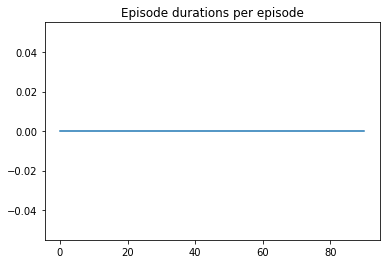

In [21]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**